In [1]:
#import necessary libraries
import pandas as pd
import pytz
from glob import glob
import warnings
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
import inspect
import time
import numpy as np
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
#input the data
files = glob('tmp*.csv')
files

['tmp37y3hzwj.csv',
 'tmpb6n1t_qb.csv',
 'tmp9uci4wac.csv',
 'tmp_424i9_2.csv',
 'tmpunyiwxpl.csv',
 'tmpzj47dpf4.csv']

In [4]:
#exploring the data
frames = [pd.read_csv(file) for file in files]
df = pd.concat(frames)
df.head()

,sensor_id;sensor_type;location;lat;lon;timestamp;value_type;value
0,50;DHT22;3573;-1.289;36.825;2023-01-01T00:00:0...
1,50;DHT22;3573;-1.289;36.825;2023-01-01T00:00:0...
2,71;pms5003;35;-1.297;36.743;2023-01-01T00:00:1...
3,71;pms5003;35;-1.297;36.743;2023-01-01T00:00:1...
4,71;pms5003;35;-1.297;36.743;2023-01-01T00:00:1...


In [3]:
# Build your `wrangle` function
def wrangle(filepath):
    
    df=pd.read_csv(filepath)
    
    #split the data
    df[["sensor_id", "sensor_type",
    'location','lat','lon','timestamp','value_type',
    'value']] = df["sensor_id;sensor_type;location;lat;lon;timestamp;value_type;value"].str.split(";", expand=True)
    
    #drop columns
    df.drop(columns="sensor_id;sensor_type;location;lat;lon;timestamp;value_type;value", inplace=True)
    
    #convert the type
    df["sensor_id"]=df["sensor_id"].astype(float)
    df['location']=df['location'].astype(float)
    df['lat']=df['lat'].astype(float)
    df['lon']=df['lon'].astype(float)
    df['value']=df['value'].astype(float)
    df['timestamp']= pd.to_datetime(df['timestamp'],format='%Y-%m-%d %H:%M:%S')
    
    #set index as timestamp
    df = df.set_index('timestamp')
    
    #convert the time in Nairobi time
    df.index=df.index.tz_convert('Africa/Nairobi')
    
    #drop columns
    drop_cols=['sensor_id', 'sensor_type','location','lat', 'lon']
    df.drop(columns=drop_cols, inplace=True)
    
    return df

In [4]:
frames = [wrangle(file) for file in files]
df = pd.concat(frames)
df.head()

,value_type,value
timestamp,,
2023-01-01 03:00:00.587438+03:00,humidity,99.9
2023-01-01 03:00:00.587438+03:00,temperature,17.1
2023-01-01 03:00:19.768006+03:00,P2,25.0
2023-01-01 03:00:19.768006+03:00,P1,35.4
2023-01-01 03:00:19.768006+03:00,P0,14.6


In [5]:
df = df[df["value_type"].str.contains("temperature") == False]
df = df[df["value_type"].str.contains("humidity") == False]
df = df[df["value_type"].str.contains("P1") == False]
df = df[df["value_type"].str.contains("P2") == False]
# Remove outliers
df = df[df["value"] < 500]
df= df['value'].resample('1H').mean().fillna(method='ffill').to_frame()

In [6]:
df['P0']=df['value']
df.drop(columns=['value'], inplace=True)

In [7]:
#data head overview
df.head()

,P0
timestamp,
2023-01-01 03:00:00+03:00,20.497552
2023-01-01 04:00:00+03:00,20.377037
2023-01-01 05:00:00+03:00,30.225940
2023-01-01 06:00:00+03:00,31.458485
2023-01-01 07:00:00+03:00,32.905060


In [8]:
df.to_csv('file3.csv')

In [8]:
df.shape

(4112, 1)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4112 entries, 2023-01-01 03:00:00+03:00 to 2023-06-21 10:00:00+03:00
Freq: H
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   P0      4112 non-null   float64
dtypes: float64(1)
memory usage: 64.2 KB


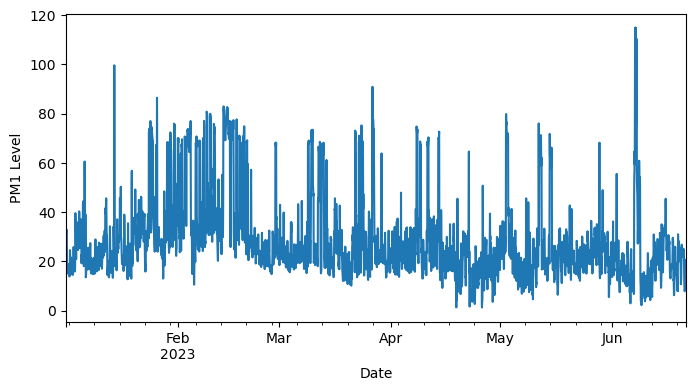

In [10]:
fig, ax = plt.subplots(figsize=(8, 4))

df['P0'].plot(xlabel='Date', ylabel='PM1 Level', ax=ax);

In [11]:
from statsmodels.tsa.stattools import adfuller

# ADF test for stationary
def adf_test(series):
    """Using an ADF test to determine if a series is stationary"""
    test_results = adfuller(series)
    print('PM1 ADF Statistic: ', test_results[0])
    print('PM1 P-Value: ', test_results[1])
    print('PM1 Critical Values:')
    for threshold, adf_stat in test_results[4].items():
        print('\t%s: %.2f' % (threshold, adf_stat))


print(adf_test(df['P0']))

PM1 ADF Statistic:  -7.272006561075844
PM1 P-Value:  1.579459575079848e-10
PM1 Critical Values:
	1%: -3.43
	5%: -2.86
	10%: -2.57
None


In [12]:
from scipy.stats import boxcox

# Make the target stationary
#df['P0_boxcox'], lam = boxcox(df['P0'])
#df["P0_stationary"] = df["P0_boxcox"].diff()
#df.dropna(inplace=True)


In [ ]:
df["P0_stationary"] = df["P0"].diff()
df.dropna(inplace=True)

In [20]:
# ADF test for stationary
def adf_test(series):
    """Using an ADF test to determine if a series is stationary"""
    test_results = adfuller(series)
    print('PM1 ADF Statistic: ', test_results[0])
    print('PM1 P-Value: ', test_results[1])
    print('PM1 Critical Values:')
    for threshold, adf_stat in test_results[4].items():
        print('\t%s: %.2f' % (threshold, adf_stat))


print(adf_test(df["P0_stationary"]))

PM1 ADF Statistic:  -16.06267133595051
PM1 P-Value:  5.616787323735381e-29
PM1 Critical Values:
	1%: -3.43
	5%: -2.86
	10%: -2.57
None


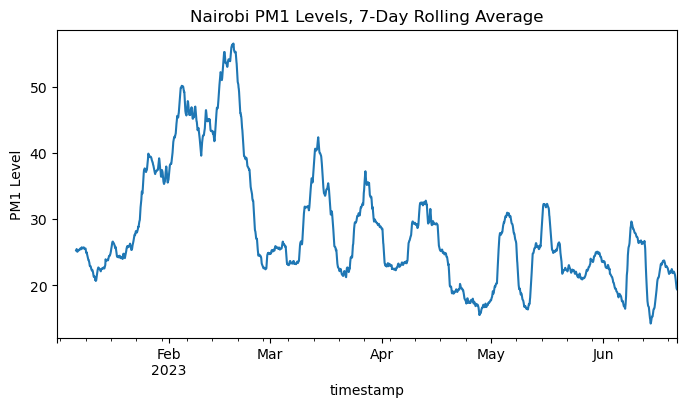

In [13]:
fig, ax = plt.subplots(figsize=(8, 4))
df["P0"].rolling(128).mean().plot(ax=ax, ylabel='PM1 Level', 
                           title="Nairobi PM1 Levels, 7-Day Rolling Average");

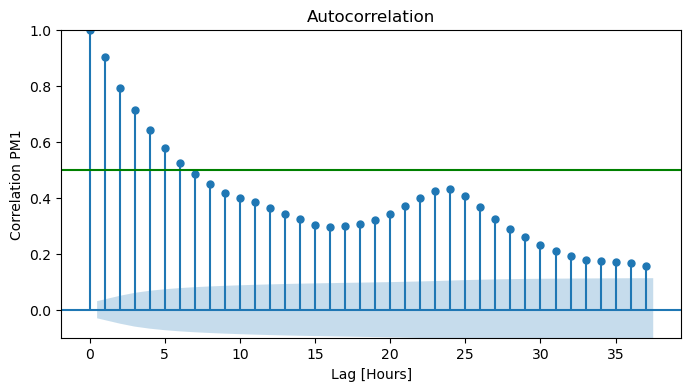

In [21]:
fig, ax = plt.subplots(figsize=(8,4))
plot_acf(df["P0"],ax=ax)
ax.set_ylim(-0.1,1)
plt.axhline(y=0.5, color='green')
plt.axhline(y=-0.5, color='green')
plt.xlabel("Lag [Hours]")
plt.ylabel("Correlation PM1")
plt.show();

In [16]:
# Import packages
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

# Split train and test
train = df['P0'].iloc[:-int(len(df['P0']) * 0.2)]
test = df['P0'].iloc[-int(len(df['P0']) * 0.2):]

# Build AR model
selector = ar_select_order(train, 36)
model = AutoReg(train, lags=selector.ar_lags).fit()

In [17]:
selector.ar_lags

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25]

In [18]:
cutoff_test = int(len(df["P0"])*0.80)
y_train = df["P0"].iloc[:cutoff_test].dropna()
y_test = df["P0"].iloc[cutoff_test:].dropna()
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (3289,)
y_test shape: (823,)


In [19]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean]*len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)


print("Mean P0 Reading:", y_train_mean)
print("Baseline MAE:", mae_baseline)

Mean P0 Reading: 29.686253541022324
Baseline MAE: 12.287781737302295


In [55]:
lag = range(1, 37)
mean_abs = []
for p in lag:
    # Note start time
    start_time = time.time()
    # Train model and fit
    model = AutoReg(y_train,lags=p).fit()
    # Calculate model training time
    elapsed_time = round(time.time() - start_time, 2)
    print(f"Trained AR {p} in {elapsed_time} seconds.")
    # Generate training predictions
    y_pred = model.predict().dropna()
    # Calculate training mean absolute errors
    mae = mean_absolute_error(y_train.iloc[p:],y_pred)
    # Append mae to mean_abs list
    mean_abs.append(mae)
mae_series = pd.Series(mean_abs, name="mae", index=lag)
mae_series.head()

Trained AR 1 in 0.01 seconds.
Trained AR 2 in 0.02 seconds.
Trained AR 3 in 0.01 seconds.
Trained AR 4 in 0.01 seconds.
Trained AR 5 in 0.01 seconds.
Trained AR 6 in 0.02 seconds.
Trained AR 7 in 0.01 seconds.
Trained AR 8 in 0.01 seconds.
Trained AR 9 in 0.01 seconds.
Trained AR 10 in 0.01 seconds.
Trained AR 11 in 0.01 seconds.
Trained AR 12 in 0.01 seconds.
Trained AR 13 in 0.01 seconds.
Trained AR 14 in 0.01 seconds.
Trained AR 15 in 0.01 seconds.
Trained AR 16 in 0.03 seconds.
Trained AR 17 in 0.02 seconds.
Trained AR 18 in 0.01 seconds.
Trained AR 19 in 0.01 seconds.
Trained AR 20 in 0.02 seconds.
Trained AR 21 in 0.01 seconds.
Trained AR 22 in 0.02 seconds.
Trained AR 23 in 0.02 seconds.
Trained AR 24 in 0.01 seconds.
Trained AR 25 in 0.02 seconds.
Trained AR 26 in 0.03 seconds.
Trained AR 27 in 0.03 seconds.
Trained AR 28 in 0.02 seconds.
Trained AR 29 in 0.02 seconds.
Trained AR 30 in 0.02 seconds.
Trained AR 31 in 0.02 seconds.
Trained AR 32 in 0.02 seconds.
Trained AR 33 in 

1    4.362193
2    4.309689
3    4.328969
4    4.327799
5    4.327622
Name: mae, dtype: float64

In [56]:
mean_abs.index(min(mean_abs))

26

In [20]:
%%capture

y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model=AutoReg(history,lags=6).fit()
    next_pred=model.forecast()
    y_pred_wfv=y_pred_wfv.append(next_pred)
    history=history.append(y_test[next_pred.index])

In [22]:
test_mae = mean_absolute_error(y_test,y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 3.29


In [27]:
test_mae = mean_squared_error(y_test,y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 29.64


In [61]:
type(y_test)

pandas.core.series.Series

In [25]:
df_pred_test=pd.DataFrame(
   {'True Values': y_test, 'Predictions':y_pred_wfv}

)
fig = px.line(df_pred_test, labels={"value": "PM1 Levels"})
fig.show()

In [32]:
mape=np.mean(np.abs(y_pred_wfv-y_test)/np.abs(y_test))
mape

0.18266903264646797

In [30]:
%%capture

y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model=AutoReg(history,lags=6).fit()
    next_pred=model.forecast()
    y_pred_wfv=y_pred_wfv.append(next_pred)
    history=history.append(y_test[next_pred.index])

In [125]:
lag=range(1, 37)
q_params=range(0,3)
# Create dictionary to store MAEs
mae_grid = dict()
# Outer loop: Iterate through possible values for `p`
for p in lag:
    # Create key-value pair in dict. Key is `p`, value is empty list.
    mae_grid[p] = list()
    # Inner loop: Iterate through possible values for `q`
    for q in q_params:
        # Combination of hyperparameters for model
        order = (p, 0, q)
        # Note start time
        start_time = time.time()
        # Train model
        model = ARIMA(y_train,order=order).fit()
        # Calculate model training time
        elapsed_time = round(time.time() - start_time, 2)
        print(f"Trained ARIMA {order} in {elapsed_time} seconds.")
        # Generate in-sample (training) predictions
        y_pred = model.predict()
        # Calculate training MAE
        mae = mean_absolute_error(y_train,y_pred)
        # Append MAE to list in dictionary
        mae_grid[p].append(mae)

print()
print(mae_grid)

Trained ARIMA (1, 0, 0) in 7.33 seconds.
Trained ARIMA (1, 0, 3) in 1.2 seconds.
Trained ARIMA (2, 0, 0) in 0.79 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Trained ARIMA (2, 0, 3) in 2.28 seconds.
Trained ARIMA (3, 0, 0) in 0.71 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (3, 0, 3) in 6.58 seconds.
Trained ARIMA (4, 0, 0) in 0.75 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (4, 0, 3) in 7.4 seconds.
Trained ARIMA (5, 0, 0) in 2.24 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (5, 0, 3) in 10.06 seconds.
Trained ARIMA (6, 0, 0) in 1.9 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (6, 0, 3) in 11.45 seconds.
Trained ARIMA (7, 0, 0) in 2.2 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (7, 0, 3) in 13.79 seconds.
Trained ARIMA (8, 0, 0) in 2.15 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (8, 0, 3) in 13.69 seconds.
Trained ARIMA (9, 0, 0) in 3.17 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (9, 0, 3) in 17.78 seconds.
Trained ARIMA (10, 0, 0) in 4.88 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (10, 0, 3) in 20.66 seconds.
Trained ARIMA (11, 0, 0) in 3.31 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (11, 0, 3) in 27.17 seconds.
Trained ARIMA (12, 0, 0) in 4.8 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (12, 0, 3) in 21.86 seconds.
Trained ARIMA (13, 0, 0) in 5.85 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (13, 0, 3) in 24.05 seconds.
Trained ARIMA (14, 0, 0) in 6.73 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (14, 0, 3) in 28.27 seconds.
Trained ARIMA (15, 0, 0) in 6.43 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (15, 0, 3) in 36.85 seconds.
Trained ARIMA (16, 0, 0) in 5.75 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (16, 0, 3) in 29.04 seconds.
Trained ARIMA (17, 0, 0) in 8.06 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (17, 0, 3) in 39.65 seconds.
Trained ARIMA (18, 0, 0) in 7.47 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (18, 0, 3) in 42.78 seconds.
Trained ARIMA (19, 0, 0) in 12.58 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (19, 0, 3) in 54.53 seconds.
Trained ARIMA (20, 0, 0) in 13.28 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (20, 0, 3) in 58.07 seconds.
Trained ARIMA (21, 0, 0) in 13.1 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (21, 0, 3) in 68.23 seconds.
Trained ARIMA (22, 0, 0) in 16.72 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (22, 0, 3) in 74.59 seconds.
Trained ARIMA (23, 0, 0) in 19.33 seconds.
Trained ARIMA (23, 0, 3) in 53.05 seconds.
Trained ARIMA (24, 0, 0) in 18.56 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (24, 0, 3) in 84.27 seconds.
Trained ARIMA (25, 0, 0) in 25.49 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (25, 0, 3) in 92.33 seconds.
Trained ARIMA (26, 0, 0) in 24.0 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (26, 0, 3) in 94.2 seconds.
Trained ARIMA (27, 0, 0) in 30.88 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (27, 0, 3) in 121.77 seconds.
Trained ARIMA (28, 0, 0) in 33.42 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (28, 0, 3) in 117.82 seconds.
Trained ARIMA (29, 0, 0) in 35.61 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (29, 0, 3) in 152.19 seconds.
Trained ARIMA (30, 0, 0) in 37.62 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (30, 0, 3) in 163.94 seconds.
Trained ARIMA (31, 0, 0) in 42.44 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (31, 0, 3) in 173.79 seconds.
Trained ARIMA (32, 0, 0) in 42.37 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (32, 0, 3) in 155.62 seconds.
Trained ARIMA (33, 0, 0) in 56.52 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (33, 0, 3) in 195.03 seconds.
Trained ARIMA (34, 0, 0) in 59.99 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (34, 0, 3) in 231.47 seconds.
Trained ARIMA (35, 0, 0) in 77.3 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (35, 0, 3) in 261.56 seconds.
Trained ARIMA (36, 0, 0) in 73.1 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (36, 0, 3) in 282.82 seconds.

{1: [4.363700796582548, 4.3298270784884805], 2: [4.313220683717164, 4.329589811671469], 3: [4.331435116876344, 4.320085889923319], 4: [4.329646505207272, 4.335017094406326], 5: [4.328107456686613, 4.320435777509833], 6: [4.327123033423853, 4.313707109747552], 7: [4.318943151667995, 4.325136712542859], 8: [4.31840620449661, 4.328825251234712], 9: [4.30872525611171, 4.323920650903076], 10: [4.288153703789724, 4.231298279077891], 11: [4.287269777046367, 4.221585300405509], 12: [4.286689340361403, 4.236354761683189], 13: [4.284627468844124, 4.317713350602295], 14: [4.289576234785656, 4.31692778977902], 15: [4.289925161638066, 4.320563060677486], 16: [4.29433839982526, 4.3196296216636085], 17: [4.305724473095384, 4.240311999589081], 18: [4.308352354569455, 4.301733707241366], 19: [4.314497391272749, 4.309792024158033], 20: [4.3129446728688, 4.230703077133918], 21: [4.290765650689786, 4.306794644931028], 22: [4.2642632087021015, 4.230452577936115]

In [126]:
mae_grid

{1: [4.363700796582548, 4.3298270784884805],
 2: [4.313220683717164, 4.329589811671469],
 3: [4.331435116876344, 4.320085889923319],
 4: [4.329646505207272, 4.335017094406326],
 5: [4.328107456686613, 4.320435777509833],
 6: [4.327123033423853, 4.313707109747552],
 7: [4.318943151667995, 4.325136712542859],
 8: [4.31840620449661, 4.328825251234712],
 9: [4.30872525611171, 4.323920650903076],
 10: [4.288153703789724, 4.231298279077891],
 11: [4.287269777046367, 4.221585300405509],
 12: [4.286689340361403, 4.236354761683189],
 13: [4.284627468844124, 4.317713350602295],
 14: [4.289576234785656, 4.31692778977902],
 15: [4.289925161638066, 4.320563060677486],
 16: [4.29433839982526, 4.3196296216636085],
 17: [4.305724473095384, 4.240311999589081],
 18: [4.308352354569455, 4.301733707241366],
 19: [4.314497391272749, 4.309792024158033],
 20: [4.3129446728688, 4.230703077133918],
 21: [4.290765650689786, 4.306794644931028],
 22: [4.2642632087021015, 4.230452577936115],
 23: [4.26025786871979

In [11]:
m={1: [4.363700796582548, 4.3298270784884805],
 2: [4.313220683717164, 4.329589811671469],
 3: [4.331435116876344, 4.320085889923319],
 4: [4.329646505207272, 4.335017094406326],
 5: [4.328107456686613, 4.320435777509833],
 6: [4.327123033423853, 4.313707109747552],
 7: [4.318943151667995, 4.325136712542859],
 8: [4.31840620449661, 4.328825251234712],
 9: [4.30872525611171, 4.323920650903076],
 10: [4.288153703789724, 4.231298279077891],
 11: [4.287269777046367, 4.221585300405509],
 12: [4.286689340361403, 4.236354761683189],
 13: [4.284627468844124, 4.317713350602295],
 14: [4.289576234785656, 4.31692778977902],
 15: [4.289925161638066, 4.320563060677486],
 16: [4.29433839982526, 4.3196296216636085],
 17: [4.305724473095384, 4.240311999589081],
 18: [4.308352354569455, 4.301733707241366],
 19: [4.314497391272749, 4.309792024158033],
 20: [4.3129446728688, 4.230703077133918],
 21: [4.290765650689786, 4.306794644931028],
 22: [4.2642632087021015, 4.230452577936115],
 23: [4.260257868719798, 4.22898117853465],
 24: [4.251019988459069, 4.230477638804707],
 25: [4.22024487817625, 4.2105986655570495],
 26: [4.211523978862007, 4.209931167607386],
 27: [4.207688155338769, 4.207573541481292],
 28: [4.207732419353988, 4.207349785831872],
 29: [4.207769975105385, 4.211255252419495],
 30: [4.208088064240398, 4.223573310932011],
 31: [4.209558895227963, 4.213238813431521],
 32: [4.210995856557836, 4.208550958868399],
 33: [4.205110428189162, 4.2001226597662615],
 34: [4.203058758070613, 4.2247130663180394],
 35: [4.202569326592699, 4.229922825716636],
 36: [4.206086495157752, 4.213144476921313]}
mae_df = pd.DataFrame(m)
mae_df.round(4)

,1,2,3,4,5,6,7,8,9,10,...,27,28,29,30,31,32,33,34,35,36
0,4.3637,4.3132,4.3314,4.3296,4.3281,4.3271,4.3189,4.3184,4.3087,4.2882,...,4.2077,4.2077,4.2078,4.2081,4.2096,4.2110,4.2051,4.2031,4.2026,4.2061
1,4.3298,4.3296,4.3201,4.3350,4.3204,4.3137,4.3251,4.3288,4.3239,4.2313,...,4.2076,4.2073,4.2113,4.2236,4.2132,4.2086,4.2001,4.2247,4.2299,4.2131


In [127]:
mae_df = pd.DataFrame(mae_grid)
mae_df.round(4)

,1,2,3,4,5,6,7,8,9,10,...,27,28,29,30,31,32,33,34,35,36
0,4.3637,4.3132,4.3314,4.3296,4.3281,4.3271,4.3189,4.3184,4.3087,4.2882,...,4.2077,4.2077,4.2078,4.2081,4.2096,4.2110,4.2051,4.2031,4.2026,4.2061
1,4.3298,4.3296,4.3201,4.3350,4.3204,4.3137,4.3251,4.3288,4.3239,4.2313,...,4.2076,4.2073,4.2113,4.2236,4.2132,4.2086,4.2001,4.2247,4.2299,4.2131


In [ ]:
y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model =ARIMA(history,order=[33,0,2]).fit()
    next_pred = model.forecast()
    y_pred_wfv = y_pred_wfv.append(next_pred)
    history = history.append(y_test[next_pred.index])

In [ ]:
test_mae = mean_absolute_error(y_test,y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))
test_mae = r2_score(y_test,y_pred_wfv)
print("Test r2 (walk forward validation):", round(test_mae, 2))

In [ ]:
df_pred_test=pd.DataFrame(
   {'y_test': y_test, 'y_pred':y_pred_wfv}

)
fig = px.line(df_pred_test, labels={"value": "PM2.5"})
fig.update_layout(
    title="Dar es Salaam Predictions",
    xaxis_title="Date",
    yaxis_title="PM2.5 Level",
)


fig.show()